                                            Effects on the US Misery Index:
For this project I am hoping to answer the question :Does the S&P or the median House Price have an effect the Misery Index ?
In order to answer this question, I am planning on using metrics from three datasets (all metrics reported monthly) from Quandl. The datasets that I am using are the Zillow, Yale, and US Misery. The final dataset has 107 rows.

The Misery Index was developed by Economist Arthur Okun in the 1970s.Arthur created this index to describe the combined affects of both inflation and unemployment. He named it the Misery index since high levels of both unemployment and inflation caused misery to the u.s citizen; the unemployment rate represents how hard it is for someone to find work and make a living while inflation represents how much of something can  be bought and affects cost of living. According to thebalance.com, a Misery index between 6 and 7 percent represents a healthy economy.

After doing some exploratory analysis of the 3 combined datasets from Quandl, I found that the correlation between the Median House Price and the US Misery Index is approximately -.8 and the correlation between the S&P and the US Misery Index is approximately -.83. Then by graphing the inflation rate and unemployment rate on a line chart, I found that inflation varied more than the unemployment rate. 

To determine which feature, median list price or s&p composite, has an effect and how much of an effect I used linear regression. I ran two linear regression models, one for each feature. I decided which of the two features has an effect by calculating the r2 score for both models. The r2 score measures how much of the variance in the data is explained. Once I determined which feature had a higher r2 score, I calculated the coefficient for that feature. The coefficent for a feature in linear regression models represents how much the label, here its S&P composite, changes when the feature changes by one unit. 

 

Below I am grabbing the 3 datasets needed for this project from Quandl for this project.

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler, Normalizer
from sklearn import metrics
import scipy.stats as stats
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset1 from the Zillow dataset on Quandl
import quandl
import pandas as pd


quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
medianlistprice=quandl.get('ZILLOW/M1_MLPAH', start_date='2010-12-31', end_date='2019-12-31') 
medianpricecut=quandl.get('ZILLOW/M1_MPCDAH', start_date='2010-12-31', end_date='2019-12-31') 
percentpricecut=quandl.get('ZILLOW/M1_PLPRAH', start_date='2010-12-31', end_date='2019-12-31') 



In [3]:

medianlistprice_df=pd.DataFrame(medianlistprice)
medianpricecut_df=pd.DataFrame(medianpricecut)
percentpricecut_df=pd.DataFrame(percentpricecut)


In [4]:

medianlistprice_df["medianlistprice"]=medianlistprice_df.values
medianpricecut_df["medianpricecut"]=medianpricecut_df.values
percentpricecut_df["percentpricecut"]=percentpricecut_df.values


In [5]:

del medianlistprice_df["Value"]
del medianpricecut_df["Value"]
del percentpricecut_df["Value"]


In [6]:

PriceConcat=pd.concat([medianlistprice_df,medianpricecut_df],axis=1,join="inner")
PriceConcatFinal=pd.concat([PriceConcat,percentpricecut_df],axis=1,join="inner")

In [7]:
#Datset2 from the US Misery Index dataset on Quandl
quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
Misery=quandl.get('USMISERY/INDEX', start_date='2005-12-31', end_date='2019-12-31')

In [8]:
Misery_df=pd.DataFrame(Misery)

In [9]:
MasterConcat=pd.concat([PriceConcatFinal,Misery_df],axis=1,join="inner")

In [10]:
quandl.ApiConfig.api_key = 'TQnvQmTWu3_mxisgXmye'
SPCOMP=quandl.get('YALE/SPCOMP', start_date='2005-12-31', end_date='2019-12-31')

In [11]:
#Dataset3 from the Yale dataset on Quandl
SPCOMP_df=pd.DataFrame(SPCOMP)
SPCOMP_df_new = SPCOMP_df.rename(index={'Year': 'Date'})

In [12]:
MasterConcat=pd.concat([PriceConcatFinal,SPCOMP_df_new],axis=1,join="inner")

In [13]:
MasterConcatFinal=pd.concat([MasterConcat,Misery_df],axis=1,join="inner")

In [14]:
#The 3 datasets from Quandl combined are placed into a Dataframe named MasterConcatFinal.Below are the first 20 rows.
print(MasterConcatFinal.head(20))

            medianlistprice  medianpricecut  percentpricecut  S&P Composite  \
2010-12-31         189500.0         10000.0        10.622925        1241.53   
2011-01-31         185000.0         10000.0        13.187245        1282.62   
2011-02-28         184900.0         10000.0        11.489166        1321.12   
2011-03-31         187900.0         10000.0        13.894619        1304.49   
2011-04-30         187500.0          9900.0        13.834944        1331.51   
2011-05-31         189900.0          9999.0        13.964655        1338.31   
2011-06-30         189900.0         10000.0        15.188460        1287.29   
2011-07-31         189900.0         10000.0        14.865479        1325.19   
2011-08-31         189900.0          9900.0        13.893364        1185.31   
2011-09-30         189500.0         10000.0        13.642534        1173.88   
2011-10-31         188888.0          9995.0        13.068290        1207.22   
2011-11-30         185000.0          9700.0        1

In [15]:
MasterConcatFinal["Month_Year"]=pd.to_datetime(MasterConcatFinal.index.values,format="%m-%d-%y")

Before looking at the relationship between the features(All columns besides the misery index and Month_Year column) and the label(misery index column), it is good practice to clean up columns that have NAN(or missing values) values. The code below counts the number of missing values in each column of our dataset.

In [16]:
MasterConcatFinal.isnull().sum()

medianlistprice                 0
medianpricecut                  0
percentpricecut                 0
S&P Composite                   0
Dividend                        3
Earnings                        3
CPI                             0
Long Interest Rate              0
Real Price                      0
Real Dividend                   3
Real Earnings                   3
Cyclically Adjusted PE Ratio    0
Unemployment Rate               0
Inflation Rate                  0
Misery Index                    0
Month_Year                      0
dtype: int64

There were four columns in our dataset that had NaN values. In order to solve this problem, I am filling the NaN values in each of the four columns with the mean of that column.


In [17]:
feature_cols =MasterConcatFinal.iloc[:1,:-2].columns

X_unscal_noNan = MasterConcatFinal[feature_cols].apply(lambda x: x.mean(),axis=0)
X_unscal_noNan=MasterConcatFinal[feature_cols[:14]].fillna(X_unscal_noNan,axis=0)
X_unscal_noNan=pd.DataFrame(X_unscal_noNan,columns=feature_cols)

With the missing values taken care of, I am ready to explore the relationship between the features and label. This is an important part so that way we know what needs to be done to take
care of issues like overfitting, which features can be used, and what model(s) to choose.

The first step I chose in exploring the dataset was to look at the correlation between the features and the label. In the correlation matrix below, both the median list price and S&P are negatively correlated with the Misery Index but are more negatively correlated with the unemployment rate which is a part of the Misery Index.

In [18]:
MasterConcatFinal.iloc[:,:-1].corr()

,medianlistprice,medianpricecut,percentpricecut,S&P Composite,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio,Unemployment Rate,Inflation Rate,Misery Index
medianlistprice,1.000000,-0.159539,0.404225,0.970963,0.968426,0.810541,0.965255,0.061530,0.965139,0.955264,0.727094,0.920686,-0.949853,-0.059507,-0.800162
medianpricecut,-0.159539,1.000000,0.336161,-0.311404,-0.316400,-0.166290,-0.287162,0.189440,-0.332884,-0.351704,-0.157201,-0.251687,0.372173,0.457009,0.486062
percentpricecut,0.404225,0.336161,1.000000,0.341008,0.332969,0.379082,0.368260,0.171438,0.332592,0.313135,0.355700,0.325887,-0.304512,0.040117,-0.232973
S&P Composite,0.970963,-0.311404,0.341008,1.000000,0.977150,0.852788,0.976087,0.073045,0.998350,0.967052,0.781249,0.952476,-0.957881,-0.117209,-0.829681
Dividend,0.968426,-0.316400,0.332969,0.977150,1.000000,0.799626,0.972240,0.004799,0.975458,0.997592,0.715398,0.899531,-0.986933,-0.230230,-0.889990
Earnings,0.810541,-0.166290,0.379082,0.852788,0.799626,1.000000,0.878904,0.283096,0.832434,0.765842,0.990064,0.774437,-0.733091,0.076082,-0.561634
CPI,0.965255,-0.287162,0.368260,0.976087,0.972240,0.878904,1.000000,-0.002409,0.965190,0.955767,0.804834,0.889037,-0.937437,-0.049793,-0.786147
Long Interest Rate,0.061530,0.189440,0.171438,0.073045,0.004799,0.283096,-0.002409,1.000000,0.077679,-0.021605,0.331152,0.240403,0.050107,0.338060,0.175456
Real Price,0.965139,-0.332884,0.332592,0.998350,0.975458,0.832434,0.965190,0.077679,1.000000,0.968726,0.760419,0.960522,-0.964554,-0.151558,-0.848802
Real Dividend,0.955264,-0.351704,0.313135,0.967052,0.997592,0.765842,0.955767,-0.021605,0.968726,1.000000,0.679277,0.890898,-0.992358,-0.279173,-0.914071


Now I am interested in seeing how my data can be grouped using kmeans clustering. Below I am droping the label column and also scaling the data. Scaling the data prevents one feature from determining how the data is being clusterd.

In [19]:
MasterConcatFinal_no_names = X_unscal_noNan.drop(X_unscal_noNan.iloc[:,14:],axis=1)
MasterConcatFinal_features = MasterConcatFinal_no_names.iloc[:1,:].columns


In [21]:
scaler_k = StandardScaler()
MasterConcatFinal_k_scaled = scaler_k.fit_transform(MasterConcatFinal_no_names[MasterConcatFinal_features])
MasterConcatFinal_k_scaled  = pd.DataFrame(MasterConcatFinal_k_scaled ,columns=MasterConcatFinal_features)
MasterConcatFinal_k_scaled

,medianlistprice,medianpricecut,percentpricecut,S&P Composite,Dividend,Earnings,CPI,Long Interest Rate,Real Price,Real Dividend,Real Earnings,Cyclically Adjusted PE Ratio,Unemployment Rate,Inflation Rate
0,-1.117872,1.752479,-1.116621,-1.452085,-1.785553,-1.452337e+00,-2.067437,1.963264,-1.426549,-1.812450e+00,-1.281852e+00,-1.018814,1.899185,-0.320111
1,-1.245709,1.752479,0.106868,-1.376370,-1.760920,-1.365215e+00,-1.957046,2.167763,-1.344077,-1.795707e+00,-1.193495e+00,-0.854085,1.735171,-0.174071
2,-1.248549,1.752479,-0.703320,-1.305426,-1.736287,-1.278094e+00,-1.842213,2.556310,-1.269012,-1.779709e+00,-1.107375e+00,-0.709281,1.680500,0.365151
3,-1.163325,1.752479,0.444371,-1.336070,-1.711654,-1.190973e+00,-1.614028,2.208662,-1.337200,-1.778767e+00,-1.057960e+00,-0.876437,1.625829,1.005477
4,-1.174688,1.657069,0.415899,-1.286281,-1.679631,-1.134652e+00,-1.461869,2.310912,-1.294455,-1.758782e+00,-1.027980e+00,-0.807198,1.680500,1.544700
5,-1.106508,1.751525,0.477786,-1.273751,-1.647608,-1.078331e+00,-1.349997,1.717866,-1.293229,-1.733772e+00,-9.857345e-01,-0.831101,1.680500,2.005285
6,-1.106508,1.752479,1.061689,-1.367764,-1.615585,-1.022010e+00,-1.375586,1.370218,-1.406654,-1.690791e+00,-9.003747e-01,-1.102478,1.735171,1.994051
7,-1.106508,1.752479,0.907588,-1.297927,-1.586025,-9.535887e-01,-1.354438,1.370218,-1.322645,-1.657066e+00,-8.132700e-01,-0.958065,1.735171,2.072688
8,-1.106508,1.657069,0.443772,-1.555681,-1.556465,-8.851676e-01,-1.288562,-0.061273,-1.649774,-1.629463e+00,-7.408311e-01,-1.683068,1.735171,2.229961
9,-1.117872,1.752479,0.324096,-1.576743,-1.526906,-8.167465e-01,-1.252188,-0.715669,-1.679880,-1.597993e+00,-6.591618e-01,-1.782638,1.680500,2.342299


After scaling the data and before I can cluster the data, I need to determine how many clusters I should split my data into.
The number of clusters is determined by the first lowest silhouette score in the range of 2 to 16 clusters.

Text(0, 0.5, 'Silhouette Coefficient')

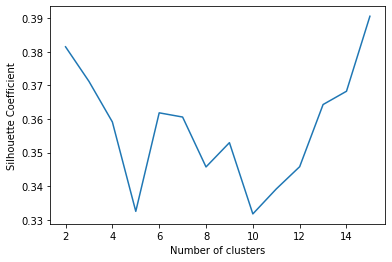

In [22]:
k_range = range(2,16)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=3)
    km_ss.fit(MasterConcatFinal_k_scaled)
    scores.append(silhouette_score(MasterConcatFinal_k_scaled, km_ss.labels_))

# plot the results
sns.mpl.pyplot.plot(k_range, scores)
sns.mpl.pyplot.xlabel('Number of clusters')
sns.mpl.pyplot.ylabel('Silhouette Coefficient')

From the above chart, the number of clusters where the silhouette coefficient score is at it's first lowest score is at 5 cluster.
Below I am running k-means with 5 clusters and then attaching the columns month year and misery index back to the dataset.

In [23]:
km5 = KMeans(n_clusters=5,random_state=1249)
km5.fit(MasterConcatFinal_k_scaled)
MasterConcatFinal_k_scaled['kmeans_five_scaled'] = [ "cluster_" + str(label) for label in km5.labels_ ]


#### When I group the resulting dataframe 'z' with the 5 different clusters by year and cluster, I see that back in 2010 where we started to emerge from the recession, that cluster 4 has low medianlistprice and S&P values in contrast to cluster 0 that had medium medianlistprice and S&P values. Now back in 2018 and 2019, a new cluster cluster3 represents high medianlistprice and S&P values. 

In [25]:
x=MasterConcatFinal_k_scaled
y=MasterConcatFinal['Month_Year'].to_list()
y=pd.DataFrame(y,columns=['monthyear'])
z=x.set_index(y.monthyear)
z['Month_Year']=pd.to_datetime(z.index.values,format="%m-%d-%y")
z['Year']=z['Month_Year'].dt.year
z_columns=['Month_Year','Year','kmeans_five_scaled','medianlistprice', 'medianpricecut', 'percentpricecut', 'S&P Composite',
       'Dividend', 'Earnings', 'CPI', 'Long Interest Rate', 'Real Price',
       'Real Dividend', 'Real Earnings', 'Cyclically Adjusted PE Ratio',
       'Unemployment Rate', 'Inflation Rate']
z_rearranged=z[z_columns]
z_rearranged.groupby(['Year','kmeans_five_scaled'])['medianlistprice','S&P Composite'].mean()
#z_rearranged.groupby('Month_Year')['medianlistprice','S&P Composite'].mean()   

medianlistprice  S&P Composite
Year kmeans_five_scaled                                
2010 cluster_4                 -1.117872      -1.452085
2011 cluster_4                 -1.174006      -1.401670
2012 cluster_2                 -1.211490      -1.184503
     cluster_4                 -1.387750      -1.343275
2013 cluster_2                 -0.913806      -0.713204
2014 cluster_0                 -0.336390      -0.141329
     cluster_2                 -0.835210      -0.386702
2015 cluster_0                 -0.043449       0.058303
2016 cluster_0                  0.400625       0.088843
     cluster_3                  0.399127       0.399993
2017 cluster_3                  0.821827       0.771455
2018 cluster_1                  1.401366       1.325175
     cluster_3                  1.044751       1.295438
2019 cluster_1                  1.618165       1.473483
     cluster_3                  1.566610       1.976146

Going back to the importance of exploring the data, in the correlation matrix I saw the features medianlistprice and S&P are highly correlated with one another. This is important to note since linear regression coefficients are used to determine the effect on the label but assume that the features used in the model are independent and normally distributed.

Below I am running 2 linear regression models ; one with the median list price and the S&P. I will 
choose the model that best describes the variance in the data(the model with the lower rmse). Doing this I am choosing which model also best describes the effect of the feature on the Misery Index. For now, I am assuming that both features are normally distributed as well which is rare.


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.stats as stats

In [27]:
feature_cols1 = ['medianlistprice']
X1 = MasterConcatFinal[feature_cols1]
feature_cols2 = ['S&P Composite']
X2 = MasterConcatFinal[feature_cols2]
y=MasterConcatFinal['Misery Index']

X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y,
                                                 test_size=0.2,
                                                 random_state=1235)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y,
                                                 test_size=0.2,
                                                 random_state=1236)

X2_linreg = LinearRegression()
X2_linreg.fit(X2_train, y2_train)
X1_linreg = LinearRegression()
X1_linreg.fit(X1_train, y1_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
y_predmed = X1_linreg.predict(X1_test)
y_predsNp = X2_linreg.predict(X2_test)

score={
       'X1':[],
       'X2':[]
     
        }
score['X1']=['The rmse score is:',np.sqrt(metrics.mean_squared_error(y1_test,y_predmed)),'for the feature Median List Price']
score['X2']=['The rmse score is:',np.sqrt(metrics.mean_squared_error(y2_test,y_predsNp)),'for the feature S&P']


scoredf=pd.DataFrame(score)
print(scoredf)

                                  X1                   X2
0                 The rmse score is:   The rmse score is:
1                            1.29441              1.27342
2  for the feature Median List Price  for the feature S&P


The rmse score is better for the model using the feature S&P than the model using the feature median list price.

In [29]:
# print the coefficients for the model using the feature S&P
print("The y intercept:", X2_linreg.intercept_)
print("The single coefficient:", X2_linreg.coef_)


print('A one unit change in S&P Composite decreases the misery index by 0.3 percent')

The y intercept: 14.334464293940265
The single coefficient: [-0.00327221]
A one unit change in S&P Composite decreases the misery index by 0.3 percent



Now I wonder if I scaled and took care of the skewness of the data (or I didn't assume the features to be normally distributed) if the S&P Composite would have a larger effect on the 
misery index and if the rmse scores will improve. 

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#below I'm scaling all values in the final dataset named MasterConcatFinal to take on values between 0 and 1
scaler = MinMaxScaler() #create a scaler object
scaler.fit(X_unscal_noNan) #fit the scaler
X_scaled = scaler.transform(X_unscal_noNan) #transform the data with it
X_scaled_df=pd.DataFrame(X_scaled,columns=feature_cols)
#X_scaled_df.head(20)

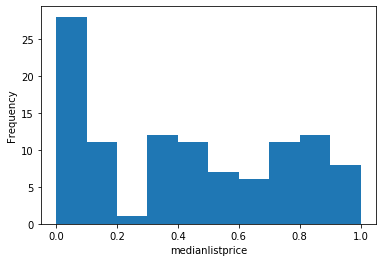

In [31]:
#Below is the distribution of the medianlistprice values prior to taking care of the skewness in the resulting distribution.
sns.mpl.pyplot.hist(X_scaled_df.medianlistprice)
sns.mpl.pyplot.xlabel("medianlistprice")
sns.mpl.pyplot.ylabel("Frequency");


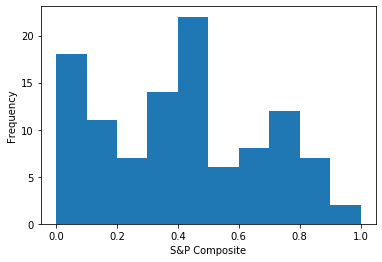

In [32]:
#Below is the distribution of the S&P composite values prior to taking care of the skewness in the resulting distribution.
sns.mpl.pyplot.hist(X_scaled_df['S&P Composite'])
sns.mpl.pyplot.xlabel('S&P Composite')
sns.mpl.pyplot.ylabel("Frequency");

In [33]:
#So the function that gets rid of skewness can't handle columns 
#where the value is zero so below I am replacing values of 0 with 0.00001
X_scaled_df=X_scaled_df.replace(to_replace=0,value=0.00001)

In [34]:
#below I am taking care of the skewness of the data in the columns medianlistprice and S&P Composite
from scipy import stats
boxcox_medianlistprice,power_val = stats.boxcox(X_scaled_df.medianlistprice)
boxcox_spcomposite,power_val2 = stats.boxcox(X_scaled_df['S&P Composite'])


Text(0.5, 0, 'BoxCox, S&P Composite')

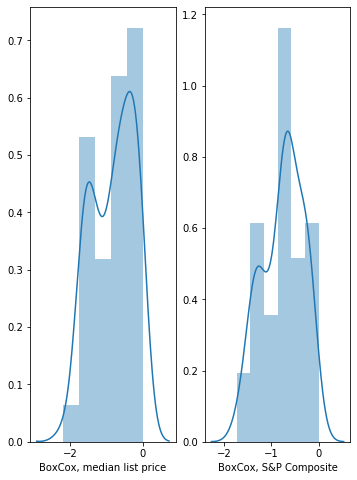

In [35]:
#Now lets see how the distributions of the values underneath the medianlistprice and S&P Composite look. I am expecting that the 
#distributions are closer to a normal distribution since linear regression models assume that the features are normally distributed.
figure = sns.mpl.pyplot.figure(figsize=(12,8))

figure.add_subplot(141)
sns.distplot(boxcox_medianlistprice)
sns.mpl.pyplot.xlabel("BoxCox, median list price")

figure.add_subplot(142)
sns.distplot(boxcox_spcomposite)
sns.mpl.pyplot.xlabel("BoxCox, S&P Composite")

Now with the data more normally distributed and scaled, I am going to run 2 linear regressions again below.

In [36]:
X_scaled_skew_MLP=pd.DataFrame(boxcox_medianlistprice)
X_scaled_skew_SP=pd.DataFrame(boxcox_spcomposite)

X_train_new_MLP,X_test_new_MLP,y_train_new_MLP,y_test_new_MLP = train_test_split(X_scaled_skew_MLP,y,
                                                 test_size=0.2,
                                                 random_state=1237)
                                                 
X_train_new_SP,X_test_new_SP,y_train_new_SP,y_test_new_SP = train_test_split(X_scaled_skew_SP,y,
                                                 test_size=0.2,
                                                 random_state=1238)
                                                 


In [37]:
#after using the linear regression model on the medianlistprice and S&P Composite after taking care of skewness in the distribution
#of values in these columns, both rmse's improved. 
X_scaled_skew_MLP_linreg = LinearRegression()
X_scaled_skew_MLP_linreg.fit(X_train_new_MLP, y_train_new_MLP)
X_scaled_skew_SP_linreg = LinearRegression()
X_scaled_skew_SP_linreg.fit(X_train_new_SP, y_train_new_SP)

y_scaled_skew_predmed = X_scaled_skew_MLP_linreg.predict(X_test_new_MLP)
y_scale_skew_predsNp = X_scaled_skew_SP_linreg.predict(X_test_new_SP)

score_scaled_skew={
       'X1':[],
       'X2':[]
     
        }
score_scaled_skew['X1']=['The rmse score is:',np.sqrt(metrics.mean_squared_error(y_test_new_MLP,y_scaled_skew_predmed)),'for the feature Median List Price']
score_scaled_skew['X2']=['The rmse score is:',np.sqrt(metrics.mean_squared_error(y_test_new_SP,y_scale_skew_predsNp)),'for the feature S&P']


score_scaled_skew_df=pd.DataFrame(score_scaled_skew)
print(score_scaled_skew_df)



                                  X1                   X2
0                 The rmse score is:   The rmse score is:
1                            1.01564             0.977807
2  for the feature Median List Price  for the feature S&P


In [38]:
# print the coefficients for the model using the feature medianlistprice after scaling and taking care of the skewed data
print("The y intercept:", X_scaled_skew_MLP_linreg.intercept_)
print("The single coefficient:", X_scaled_skew_MLP_linreg.coef_)


# print the coefficients for the model using the feature S&P Composite after scaling and taking care of the skewed data
print("The y intercept:", X_scaled_skew_SP_linreg.intercept_)
print("The single coefficient:", X_scaled_skew_SP_linreg.coef_)

The y intercept: 4.969320636129636
The single coefficient: [-3.48691414]
The y intercept: 4.245752924405075
The single coefficient: [-4.55929254]


Now I wonder what would happen if I did some PCA and then ran a linear regression 50-Fold mondel on both the medianlistprice and S&P Composite . PCA is used as a way to make features that are dependent on one another not dependent on one another. 

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures



In [45]:
X_scaled_skew_features=['S&P Composite','MedianListPrice']
X_scaled_skew=pd.concat([X_scaled_skew_MLP,X_scaled_skew_SP],axis=1,join='inner')
pca = PCA()
transformed_pca_x = pca.fit_transform(X_scaled_skew)
#create component indices
component_names = ["component_"+str(comp) for comp in range(1, len(pca.explained_variance_)+1)]

component_matrix = pd.DataFrame(pca.components_,index=component_names,columns = ['S&P Composite','MedianListPrice'])


In [51]:
#PCA linearly combines features in order to make them independent of one another. After PCA, components (composed of a mixture of features)
#, we want to see which component explains most of the variance in the data. Below, component1 explains most of the variance
#in the data. Next, let look at the component_matrix to see how much of a feature is associated with component1.


,S&P Composite,MedianListPrice,explained_variance_ratio,eigenvalue
component_1,-0.806609,-0.591085,0.979333,0.504544
component_2,0.591085,-0.806609,0.020667,0.010647


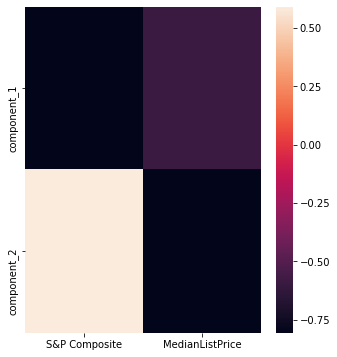

In [50]:

component_matrix["explained_variance_ratio"] = pca.explained_variance_ratio_
component_matrix["eigenvalue"] = pca.explained_variance_
figure = sns.mpl.pyplot.figure(figsize=(18,6))


#component matrix
figure.add_subplot(131)
sns.heatmap(component_matrix.iloc[:,:-2])
component_matrix.iloc[:,:]

In [ ]:
#In the matrix above Component1, a column that was created after PCA and is made up of both features medianlistprice and S&P
#,is composed more of the median list price than the S&P Composite.

#now lets do a 50 fold on our PCA data

In [49]:
lr=LinearRegression()
mean_squared_errors = np.abs(cross_val_score(lr,pd.DataFrame(transformed_pca_x).iloc[:,:2],y,cv=50,scoring='neg_mean_squared_error'))
#apply square root to each fold
root_mean_squared_errors = list(map(np.sqrt,mean_squared_errors))
print("50-fold mean RMSE: ", np.mean(root_mean_squared_errors))
print("50-fold std RMSE: ", np.std(root_mean_squared_errors))

50-fold mean RMSE:  0.8553079837030654
50-fold std RMSE:  0.6416578601144652


In [ ]:
# The 50 fold on our scaled_skew data performed the best out of all models with a rmse of .855.